# Age associations per SNV

## 1. prepare the matrix

In [2]:
import pandas as pd
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [4]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_52919/1174477373.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [5]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [6]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [7]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })
ukb200K_ch_cancer

,patient,age_recruitment_x,age_group_x,CH_driver,CH_driver_big,CH_driver_small,CH_potential,CH_nonDriver,num_CH_drivers,CH_driver_multiple,num_CH_potential,ASXL1_driver,ASXL1_passenger,ASXL1_potential,CHEK2_driver,CHEK2_passenger,CHEK2_potential,DNMT3A_driver,DNMT3A_passenger,DNMT3A_potential,GNAS_driver,GNAS_passenger,GNAS_potential,IDH2_driver,IDH2_passenger,IDH2_potential,MDM4_driver,MDM4_passenger,MDM4_potential,PPM1D_driver,PPM1D_passenger,PPM1D_potential,SF3B1_driver,SF3B1_passenger,SF3B1_potential,SRSF2_driver,SRSF2_passenger,SRSF2_potential,TET2_driver,TET2_passenger,TET2_potential,TP53_driver,TP53_passenger,TP53_potential,U2AF1_driver,U2AF1_passenger,U2AF1_potential,chromatin_gene_driver,DDR_gene_driver,splicing_gene_driver,chromatin_gene_passenger,DDR_gene_passenger,splicing_gene_passenger,chromatin_gene_potential,DDR_gene_potential,splicing_gene_potential,age_recruitment_y,age_group_y,eid,cancer,cancer2+,age_1cancer,years_tocancer1,cancer1_pre,type_1cancer,hemato_cancer,hematocancer_icd10_type,hematocancer_icd10_age,hematocancer_icd9_type,hematocancer_icd9_age,hematocancer_type,hematocancer_age,hematocancer_icd10_date,hematocancer_icd9_date,hematocancer_date,...,var_Melanoma_var,var_Melanoma_post,var_Melanoma_pre,var_Lymphoma_years,var_Lymphoma_var,var_Lymphoma_post,var_Lymphoma_pre,var_Myeloma_years,var_Myeloma_var,var_Myeloma_post,var_Myeloma_pre,var_Kidney_years,var_Kidney_var,var_Kidney_post,var_Kidney_pre,var_Head-neck_years,var_Head-neck_var,var_Head-neck_post,var_Head-neck_pre,var_Brain_years,var_Brain_var,var_Brain_post,var_Brain_pre,var_Bladder_years,var_Bladder_var,var_Bladder_post,var_Bladder_pre,var_Pancreas_years,var_Pancreas_var,var_Pancreas_post,var_Pancreas_pre,var_Uterine_years,var_Uterine_var,var_Uterine_post,var_Uterine_pre,var_Oesophageal_years,var_Oesophageal_var,var_Oesophageal_post,var_Oesophageal_pre,var_Ovarian_years,var_Ovarian_var,var_Ovarian_post,var_Ovarian_pre,var_Stomach_years,var_Stomach_var,var_Stomach_post,var_Stomach_pre,var_Liver_years,var_Liver_var,var_Liver_post,var_Liver_pre,var_Thyroid_years,var_Thyroid_var,var_Thyroid_post,var_Thyroid_pre,var_Biliari_years,var_Biliari_var,var_Biliari_post,var_Biliari_pre,var_Cervical_years,var_Cervical_var,var_Cervical_post,var_Cervical_pre,var_Sarcoma_years,var_Sarcoma_var,var_Sarcoma_post,var_Sarcoma_pre,var_Testicular_years,var_Testicular_var,var_Testicular_post,var_Testicular_pre,var_HNALL_years,var_HNALL_var,var_HNALL_post,var_HNALL_pre
0,1000019,54,51-55,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,54,51-55,1000019,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0
1,1000022,53,51-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,51-55,1000022,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0
2,1000035,59,56-60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,56-60,1000035,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0
3,1000046,45,38-45,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,45,38-45,1000046,1,0,53.3,8.3,0,D051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,

In [8]:
# Remove cases with prior hematological cancer
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer)

467202

In [9]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [10]:
# Select only mutations from patients without prior hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].astype(int).isin(non_HN_patients)]
boostDM_predictions_nonHN = boostDM_predictions_nonHN.reset_index(drop=True) 
len(boostDM_predictions_nonHN)

201857

## 2. Select mutaitons that ocurr as a single mutations in a case

In [11]:
num_mut = boostDM_predictions_nonHN['patient'].value_counts().reset_index()
uni_mut_patients = num_mut[num_mut['patient']==1]['index'].tolist()
len(uni_mut_patients)

113415

In [12]:
boostDM_predictions_unique = boostDM_predictions_nonHN[boostDM_predictions_nonHN['patient'].isin(uni_mut_patients)]
len(boostDM_predictions_unique)

113415

In [13]:
# Now select those ocurring in >= 30 patients
Recurrent_Mut = boostDM_predictions_unique['ID2'].value_counts().reset_index()
Recurrent_Mut = Recurrent_Mut[Recurrent_Mut['ID2']>=30]['index'].str.replace('-', '_').to_list()
len(Recurrent_Mut)

392

In [29]:
# Include columns with the specific mutations
from tqdm import tqdm
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for i in tqdm(Recurrent_Mut):  
    gene_CH_patient = boostDM_predictions_unique[boostDM_predictions_unique['ID2'] == i.replace('_', '-')]['patient'].astype(str).to_list()
    ukb200K_ch_cancer['var_'+i] = np.where(ukb200K_ch_cancer['patient'].astype(str).isin(gene_CH_patient), 1, 0)
ukb200K_ch_cancer

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 392/392 [01:30<00:00,  4.31it/s]


,patient,age_recruitment_x,age_group_x,CH_driver,CH_driver_big,CH_driver_small,CH_potential,CH_nonDriver,num_CH_drivers,CH_driver_multiple,num_CH_potential,ASXL1_driver,ASXL1_passenger,ASXL1_potential,CHEK2_driver,CHEK2_passenger,CHEK2_potential,DNMT3A_driver,DNMT3A_passenger,DNMT3A_potential,GNAS_driver,GNAS_passenger,GNAS_potential,IDH2_driver,IDH2_passenger,IDH2_potential,MDM4_driver,MDM4_passenger,MDM4_potential,PPM1D_driver,PPM1D_passenger,PPM1D_potential,SF3B1_driver,SF3B1_passenger,SF3B1_potential,SRSF2_driver,SRSF2_passenger,SRSF2_potential,TET2_driver,TET2_passenger,TET2_potential,TP53_driver,TP53_passenger,TP53_potential,U2AF1_driver,U2AF1_passenger,U2AF1_potential,chromatin_gene_driver,DDR_gene_driver,splicing_gene_driver,chromatin_gene_passenger,DDR_gene_passenger,splicing_gene_passenger,chromatin_gene_potential,DDR_gene_potential,splicing_gene_potential,age_recruitment_y,age_group_y,eid,cancer,cancer2+,age_1cancer,years_tocancer1,cancer1_pre,type_1cancer,hemato_cancer,hematocancer_icd10_type,hematocancer_icd10_age,hematocancer_icd9_type,hematocancer_icd9_age,hematocancer_type,hematocancer_age,hematocancer_icd10_date,hematocancer_icd9_date,hematocancer_date,...,var_2_25313923_C,var_4_105272774_T,var_20_58854119_T,var_20_32433379_A,var_20_58855058_A,var_17_60663169_A,var_17_76736913_T,var_4_105259629_A,var_4_105272735_T,var_4_105234310_A,var_20_32436659_A,var_20_58855190_A,var_2_25240402_A,var_2_25247595_A,var_17_60656651_A,var_2_197409844_A,var_2_25247704_A,var_17_7673773_A,var_4_105235707_G,var_4_105235376_C,var_2_25234286_T,var_2_25247676_G,var_17_76736454_A,var_1_204530715_G,var_20_32436677_G,var_2_25247616_T,var_20_58854799_T,var_20_32434610_G,var_2_25244559_T,var_15_90084840_A,var_2_25244580_A,var_20_32435270_T,var_2_25234295_C,var_2_25246623_T,var_2_25244633_A,var_20_32434934_T,var_2_25241582_A,var_4_105269662_A,var_2_25234380_C,var_4_105236925_C,var_2_25234307_T,var_20_32431396_A,var_4_105243584_G,var_4_105275065_A,var_2_25282695_T,var_22_28695800_C,var_20_58854034_A,var_15_90091592_C,var_2_25240402_T,var_20_32436329_T,var_17_76736926_T,var_20_32436671_T,var_20_58853662_C,var_4_105234664_T,var_2_25247691_T,var_2_25244329_T,var_20_32435226_T,var_20_32437157_T,var_2_25248099_T,var_15_90102365_T,var_2_25234346_T,var_20_32436347_T,var_17_7675070_T,var_15_90084346_C,var_4_105235590_T,var_17_7674229_T,var_17_60600556_A,var_17_60656663_A,var_22_28695753_A,var_20_32431604_T,var_2_25234367_A,var_20_32436374_A,var_17_60663341_A,var_22_28695827_C,var_20_58903684_A
0,1000019,54,51-55,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,54,51-55,1000019,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000022,53,51-55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,51-55,1000022,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000035,59,56-60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,56-60,1000035,0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000046,45,38-45,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,45,38-45,1000046,1,0,53.3,8.3,0,D051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000054,65,61-65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [30]:
#Remove cases with prior hemathological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

467202

In [14]:
# Select the 392 frequent mutations
Rec_Mut = boostDM_predictions_unique['ID2'].value_counts().reset_index()
Rec_Mut = Rec_Mut[Rec_Mut['ID2']>=30]['index'].to_list()
Rec_Mut = boostDM_predictions_unique[boostDM_predictions_unique['ID2'].isin(Rec_Mut)]

In [34]:
Mut_case = []
for gene in Rec_Mut['SYMBOL'].unique():
    freq_driv = len(Rec_Mut[(Rec_Mut['SYMBOL']==gene)&(Rec_Mut['boostDM_score']>=0.9)])
    freq_posdriver = len(Rec_Mut[(Rec_Mut['SYMBOL']==gene)&(Rec_Mut['boostDM_score']>=0.5)&(Rec_Mut['boostDM_score']<0.9)])
    freq_posnondriver = len(Rec_Mut[(Rec_Mut['SYMBOL']==gene)&(Rec_Mut['boostDM_score']>0.1)&(Rec_Mut['boostDM_score']<0.5)])
    freq_nondriver = len(Rec_Mut[(Rec_Mut['SYMBOL']==gene)&(Rec_Mut['boostDM_score']<=0.1)])
    Mut_case.append([gene, freq_driv, freq_posdriver, freq_posnondriver, freq_nondriver])

In [35]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Drivers', 'Pos_Driver', 'Pos_nonDriver', 'nonDrivers']).sort_values('Drivers', ascending=False)
Mut_case.reset_index()

,index,Gene,Drivers,Pos_Driver,Pos_nonDriver,nonDrivers
0,1,DNMT3A,5262,1394,180,1283
1,2,TET2,480,629,964,3525
2,6,CHEK2,376,175,1483,1078
3,0,ASXL1,232,0,0,5459
4,5,PPM1D,210,0,0,2556
5,8,SRSF2,191,0,57,594
6,4,GNAS,121,0,30,3454
7,10,SF3B1,103,45,209,336
8,9,TP53,92,191,0,641
9,3,IDH2,44,0,0,1027


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


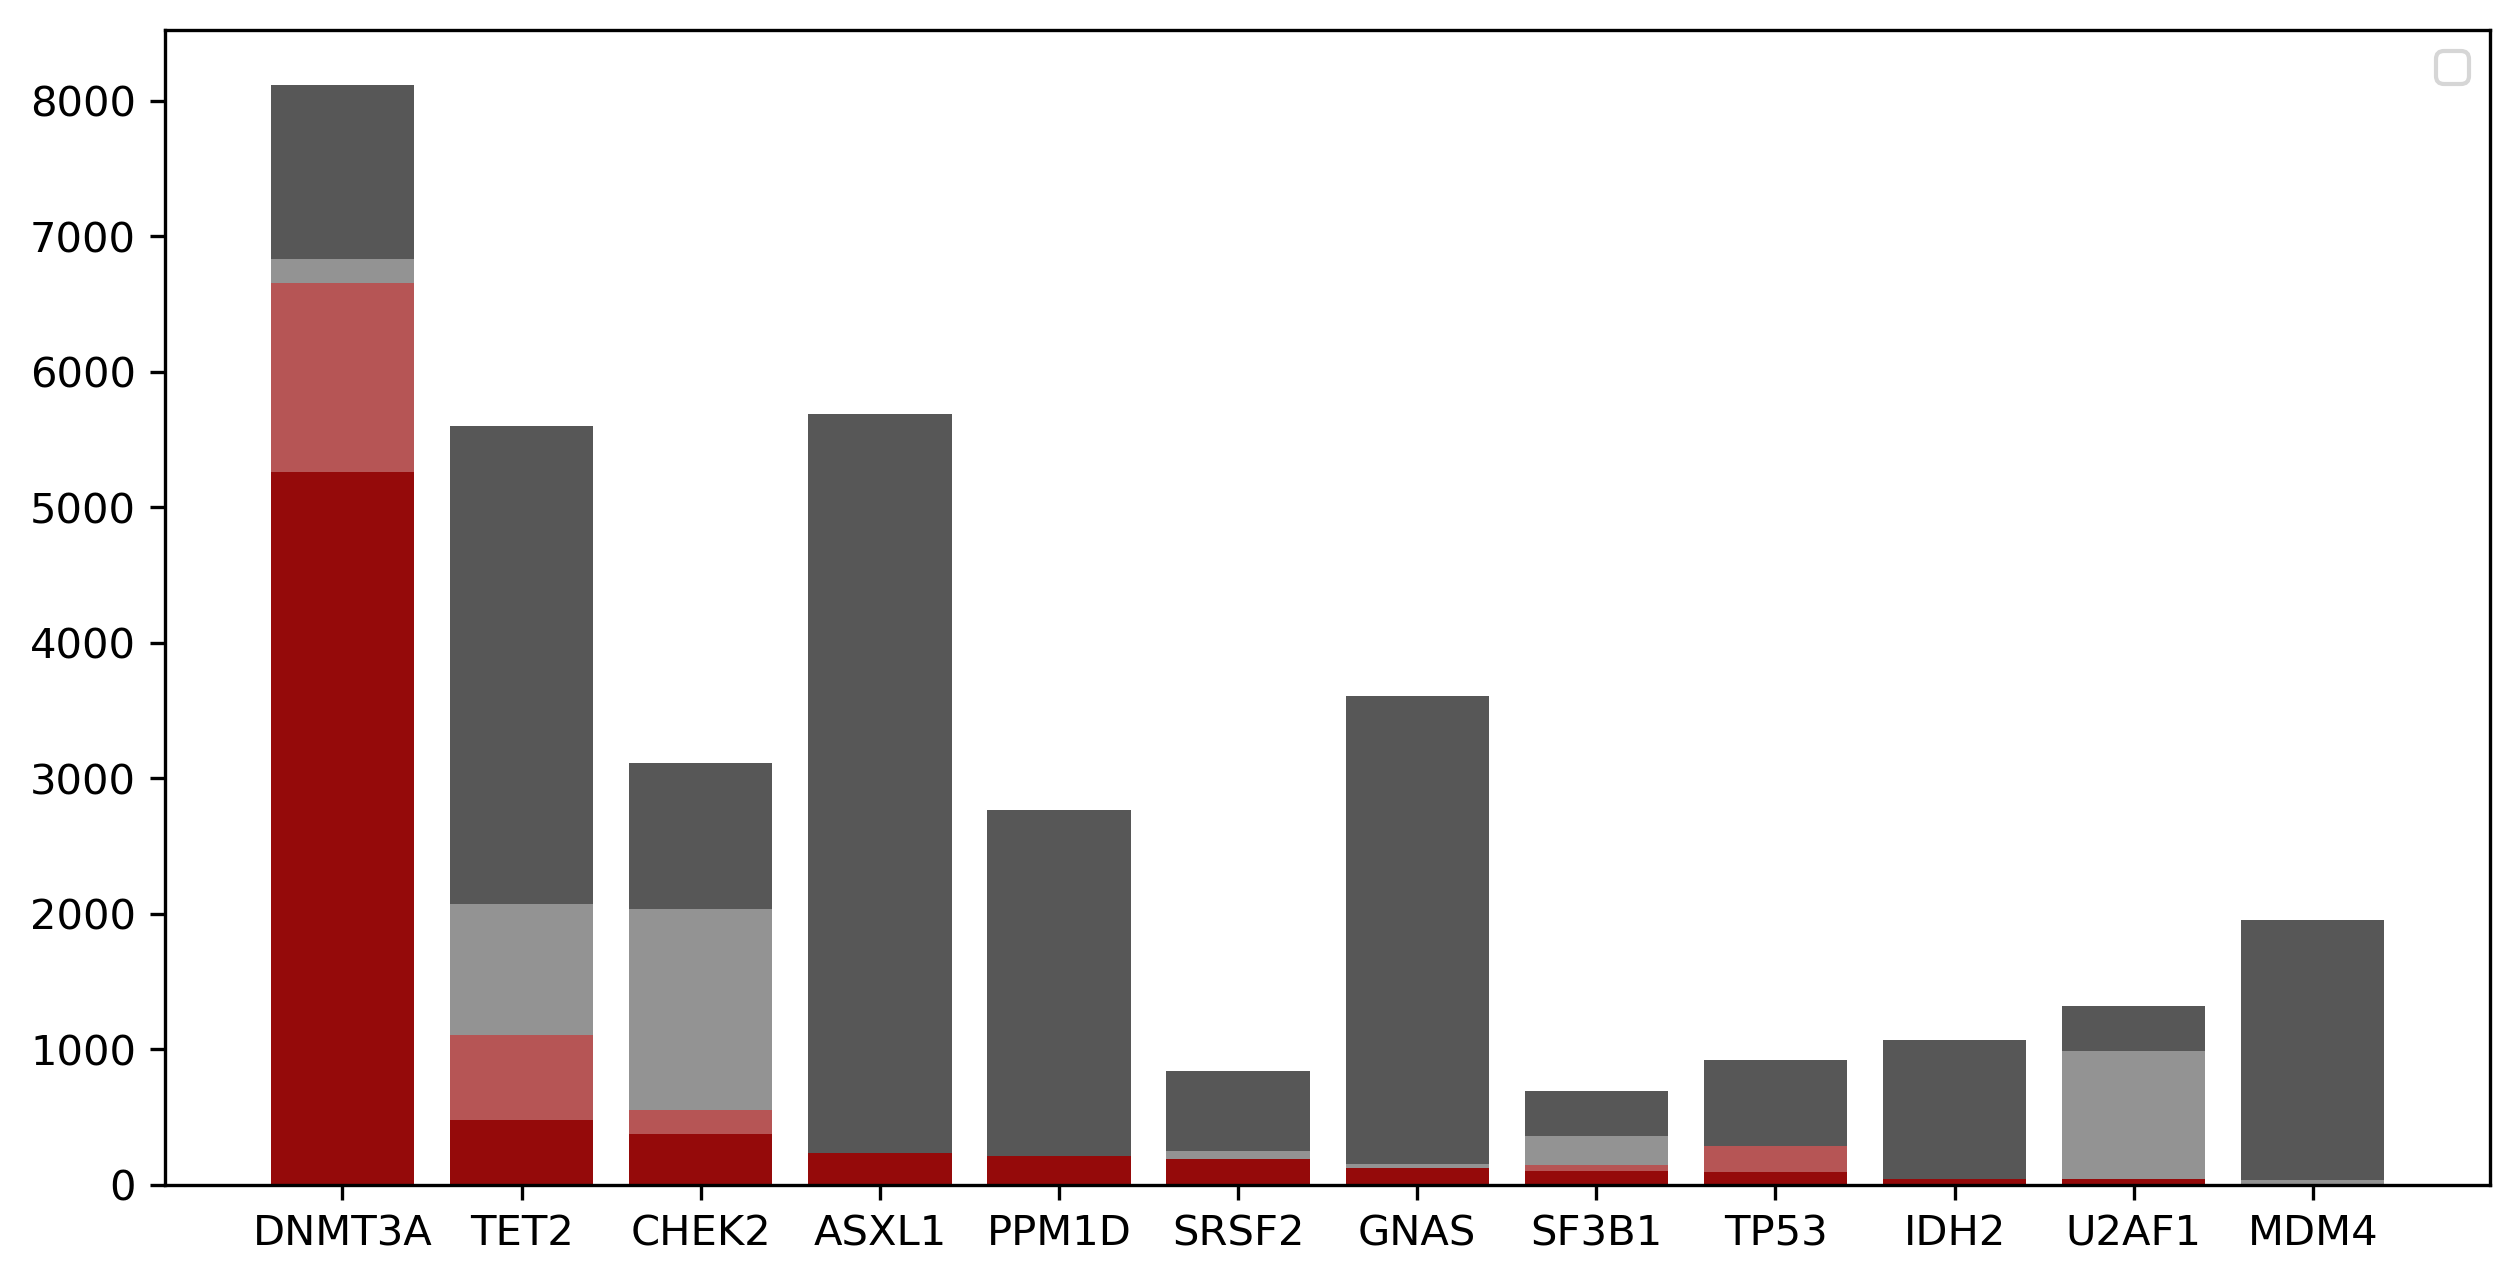

In [36]:
# importing package
import matplotlib.pyplot as plt
color = ['#575757', '#939393', '#B65555', '#950A0A']

# plt.figure(figsize=(10, 5), dpi=300)
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
# create data
x = Mut_case['Gene']
y1 = Mut_case['Drivers']
y2 = Mut_case['Pos_Driver']
y3 = Mut_case['Pos_nonDriver']
y4 = Mut_case['nonDrivers']
 
# plot bars in stack manner
plt.bar(x, y1, color=color[3])
plt.bar(x, y2, bottom=y1, color=color[2])
plt.bar(x, y3, bottom=y1+y2, color=color[1])
plt.bar(x, y4, bottom=y1+y2+y3, color=color[0])
leg = ax.legend()
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.savefig('gene_profile.png', dpi=300)
plt.show()

## 3. Age association per SNV

In [37]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

gene_results = []
for gene in tqdm(Recurrent_Mut):
    
    mat_gene = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic['var_'+gene]==1) |\
                                          (ukb200K_ch_cancer_logistic['CH_potential']==0)]
    
    ## Get number of mutated samples and percentage
    num_mut = len(mat_gene[(mat_gene['var_'+gene]==1)])
    
    BDM_score = max(boostDM_predictions[boostDM_predictions['ID2']==gene.replace('_', '-')]['boostDM_score'])

    if BDM_score >=0.9:
        BDM_pred = 'driver'
    elif BDM_score <=0.1:
        BDM_pred = 'nondriver'
    elif (BDM_score>=0.5)&(BDM_score<0.9):
        BDM_pred = 'possdriver'
    elif (BDM_score>0.1)&(BDM_score<0.5):
        BDM_pred = 'possnondriver'
    
    ## Logistic regression
    formula= 'var_'+gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10'

    ## Exception to avoid LinAlgError
    try:
            
        # Logistic regression
        model = smf.logit(formula=formula, data=mat_gene).fit(disp=0)
            
        # Get parameters from the logistic regression
        p = model.pvalues[1]
        odds = np.exp(model.params[1])
        conint1 = np.exp(model.conf_int().iloc[1,0])
        conint2 = np.exp(model.conf_int().iloc[1,1])
        prsquared = model.prsquared
            
        results = [gene, num_mut, p, odds, conint1, conint2, prsquared, BDM_score, BDM_pred]
        
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(gene, num_mut,  message)
        results = [gene, num_mut, 1 ,np.nan, np.nan, np.nan, np.nan, BDM_score, BDM_pred]
            
    
    ## Append results    
    gene_results.append(results)
    
# Get dataframe
output = pd.DataFrame(gene_results, columns=["Mutation_id", "num_mut", "p_value", "odds_ratio","confint_1st", "confint_2nd", "pseudoR2", "BDM_score", "BDM_pred"])
output["q_value"] = mtc.fdrcorrection(pd.to_numeric(output['p_value']))[1]
output['sig'] = ['sig' if pval <= 0.05 else 'ns' for pval in output.q_value]
output = output[["Mutation_id", "num_mut", "p_value", "q_value", "sig", "odds_ratio", "confint_1st", "confint_2nd", "pseudoR2", "BDM_score", "BDM_pred"]]

output

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 392/392 [34:37<00:00,  5.30s/it]


,Mutation_id,num_mut,p_value,q_value,sig,odds_ratio,confint_1st,confint_2nd,pseudoR2,BDM_score,BDM_pred
0,21_43094716_A,883,9.529518e-01,9.948610e-01,ns,0.999752,0.991554,1.008018,0.001314,0.129913,possnondriver
1,2_25234373_T,877,6.907319e-17,1.353834e-14,sig,1.038416,1.029267,1.047647,0.007683,0.999207,driver
2,1_204538255_G,667,2.439289e-01,6.235932e-01,ns,0.994423,0.985111,1.003822,0.025839,0.052345,nondriver
3,4_105272685_C,660,5.608813e-01,8.681582e-01,ns,0.997190,0.987779,1.006691,0.000841,0.385936,possnondriver
4,2_25234374_A,570,4.658568e-16,6.087195e-14,sig,1.047600,1.035907,1.059425,0.010473,0.999008,driver
...,...,...,...,...,...,...,...,...,...,...,...
387,2_25234367_A,30,6.953894e-01,9.075011e-01,ns,1.009065,0.964496,1.055694,0.016863,0.966625,driver
388,20_32436374_A,30,7.399267e-01,9.236188e-01,ns,0.992620,0.950145,1.036995,0.154860,0.000013,nondriver
389,17_60663341_A,30,5.320000e-02,2.343191e-01,ns,0.957475,0.916210,1.000600,0.058874,0.000038,nondriver
390,22_28695827_C,30,3.253480e-01,7.142543e-01,ns,0.978247,0.936299,1.022074,0.033388,0.992880,driver


In [38]:
output['BDM_pred_simple'] = output['BDM_pred'].apply(lambda x: 'driver' if x in(['driver', 'possdriver']) else 'nondriver')
output

,Mutation_id,num_mut,p_value,q_value,sig,odds_ratio,confint_1st,confint_2nd,pseudoR2,BDM_score,BDM_pred,BDM_pred_simple
0,21_43094716_A,883,9.529518e-01,9.948610e-01,ns,0.999752,0.991554,1.008018,0.001314,0.129913,possnondriver,nondriver
1,2_25234373_T,877,6.907319e-17,1.353834e-14,sig,1.038416,1.029267,1.047647,0.007683,0.999207,driver,driver
2,1_204538255_G,667,2.439289e-01,6.235932e-01,ns,0.994423,0.985111,1.003822,0.025839,0.052345,nondriver,nondriver
3,4_105272685_C,660,5.608813e-01,8.681582e-01,ns,0.997190,0.987779,1.006691,0.000841,0.385936,possnondriver,nondriver
4,2_25234374_A,570,4.658568e-16,6.087195e-14,sig,1.047600,1.035907,1.059425,0.010473,0.999008,driver,driver
...,...,...,...,...,...,...,...,...,...,...,...,...
387,2_25234367_A,30,6.953894e-01,9.075011e-01,ns,1.009065,0.964496,1.055694,0.016863,0.966625,driver,driver
388,20_32436374_A,30,7.399267e-01,9.236188e-01,ns,0.992620,0.950145,1.036995,0.154860,0.000013,nondriver,nondriver
389,17_60663341_A,30,5.320000e-02,2.343191e-01,ns,0.957475,0.916210,1.000600,0.058874,0.000038,nondriver,nondriver
390,22_28695827_C,30,3.253480e-01,7.142543e-01,ns,0.978247,0.936299,1.022074,0.033388,0.992880,driver,driver


In [39]:
output.to_csv("output_Age_association_20230802.txt.gz", sep="\t", index=False, compression='gzip')